In [1]:
import numpy as np
from scipy import linalg
from math import pi
from quantum.utils import plotting as PLT

In [2]:
states=np.array([
    (0,0,0),
    (1,0,0),
    (0,0,1),
    (0,1,0),
    (0,0,2),
    (1,1,0),
    (0,1,1),
    (1,0,2)
])
Nstates = len(states)

Hgate = np.array([[1,1,0,0],[1,-1,0,0],[0,0,1,1],[0,0,1,-1]])/np.sqrt(2)
CN = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

statevec = dict([(tuple(state), i) for i, state in enumerate(states)])

photon_states=[(0,0),(1,0),(0,1),(1,1)]
Nphoton_states = len(photon_states)

def partial_trace_atom( matrix ):
    output = np.zeros((Nphoton_states, Nphoton_states),dtype=matrix.dtype)
    for na in [0,1,2]:
        for row,bra in enumerate(photon_states):
            for col,ket in enumerate(photon_states):
                full_bra = bra + (na,)
                full_ket = ket + (na,)
                if full_bra in statevec and full_ket in statevec:
                    i = statevec[full_bra]
                    j = statevec[full_ket]
                    output[row,col] += matrix[i,j]
    return output

def projection( matrix, na1, na2 ):
    output = np.zeros((Nphoton_states, Nphoton_states),dtype=matrix.dtype)
    for row,bra in enumerate(photon_states):
        for col,ket in enumerate(photon_states):
            full_bra = bra + (na1,)
            full_ket = ket + (na2,)
            if full_bra in statevec and full_ket in statevec:
                i = statevec[full_bra]
                j = statevec[full_ket]
                output[row,col] += matrix[i,j]
                #print(row,col,':',full_bra,',',full_ket,';',i,',',j,';', np.abs(matrix[i,j]))
    return output


In [3]:
def Hamiltonian(delta, ga, gb):
    H = np.zeros((Nstates,Nstates))
    H[0,0] = delta
    H[1:3,1:3] = [[-delta, ga],[ga, delta]]
    H[3:5,3:5] = [[-delta, gb],[gb, delta]]
    np.fill_diagonal(H[5:,5:],[-delta,delta,delta])
    H[5,[6,7]] = [ga,gb]
    H[[6,7],5] = [ga,gb]
    return H

def EvolutionOperator(H,t):
    # H = V diag(E) V^T 
    E,V = np.linalg.eigh(H)
    return V @ np.diag(np.exp(-1j*E*t)) @ V.T

## Krauss Operator form for the reduced dynamics

In [4]:
H = Hamiltonian(0.2,1,1)
def reduced_prop(R0,U):
    W = [projection(U, a,0) for a in [0,1,2]]
    R = np.sum([w @ R0 @ w.conj().T for w in W],axis=0)
    return R

def phase(z):
    phi = np.arctan2(z.imag, z.real)
    #phi += 2*pi if phi < -1e-4 else 0
    return phi

Note that the different blocks of the Hamiltonians have different reference energies. This does not cause a problem in the exponentiation since the different blocks are not coupled. However, it does matter when we compare relative phase shift between the states in each block. 

In the first block with 1 photon + atom, the reference energy is $\omega + \delta$. In the second block, with an additional photon, the reference energy has an extra $\omega$ component from the second photon.

In the calculaion below, I define the total phase of the states with respect to the phase they would have at zero coupling. For the states with atom in the ground state, the phase is $\delta$ when exponentiating as $e^{-iHt}$. Thus the relative phase shift between the states $\psi_a$, $\psi_b$ and $\psi_{ab}$ is 

$$  \Delta =  \phi_{ab} - \delta - (\phi_a-\delta) - (\phi_b-\delta). $$

Text(0, 0.5, 'Relative Phase [deg]')

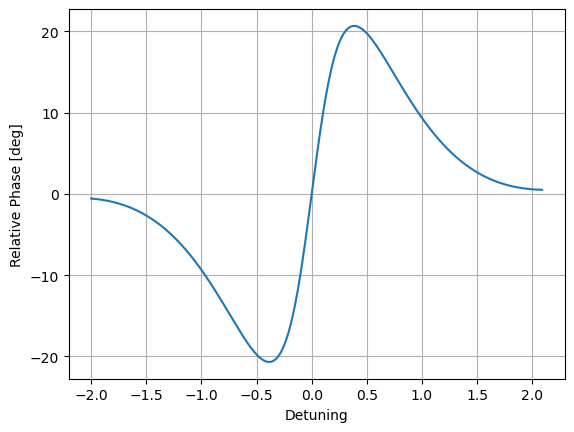

In [5]:
def getW0(delta,ga,gb,t):
    H = Hamiltonian(delta, ga,gb)
    U = EvolutionOperator(H, t)
    W0 = projection(U, 0, 0)
    return W0

detune = np.arange(-2,2.1,0.01)
phi=[]
g = 1
for d in detune:
    W0 = getW0(d, 1, 1, 0.98)
    phi += [[phase(w) for w in np.diagonal(W0)]]
phi = np.array(phi)

fig,ax=PLT.subplots()
ax.plot(detune, (phi[:,3]-phi[:,1]-phi[:,2] + detune) * 180/pi)
ax.grid(True)
ax.set_xlabel('Detuning')
ax.set_ylabel('Relative Phase [deg]')

In [6]:
R0 = np.diag([0,0.,0,1])
W0 = getW0(0.5,1,1,1)
W0p = np.diag(np.diagonal(W0)/np.abs(np.diagonal(W0)))
with np.printoptions(precision=2):
    print(np.abs(W0))
    print(np.arctan2(W0p.imag, W0p.real))

[[1.   0.   0.   0.  ]
 [0.   0.59 0.   0.  ]
 [0.   0.   0.59 0.  ]
 [0.   0.   0.   0.34]]
[[-0.5   0.    0.    0.  ]
 [ 0.    0.74  0.    0.  ]
 [ 0.    0.    0.74  0.  ]
 [ 0.    0.    0.    1.36]]


In [7]:
K = CN @ linalg.inv(W0p) 

In [8]:
with np.printoptions(precision=2):
    print(K)

[[0.88+0.48j 0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.74-0.68j 0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.21-0.98j]
 [0.  +0.j   0.  +0.j   0.74-0.68j 0.  +0.j  ]]


In [9]:
linalg.det(K[2:,2:])

(0.508776030196507+0.8608989203718882j)